MobileNet: Designed for mobile and embedded vision applications, it is efficient in terms of speed and memory usage.

Step 1: Set constant values

In [1]:
DATA_FILEPATH = ".\\dataset_26"
IMAGE_SIZE = (256, 256)
SEED = 2837373

Step 2: Load and Preprocess Data

In [8]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

def load_data(folder_path):
    data = []
    for img in os.listdir(folder_path):
        try:
            img_path = os.path.join(folder_path, img)
            img = Image.open(img_path).convert('RGB')
            img = img.resize(IMAGE_SIZE)
            img_array = np.array(img)
            data.append(img_array)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return np.array(data)


data_list = []
labels_list = []
categories = ['notumor', 'glioma', 'meningioma', 'pituitary']
for category in categories:
    data_temp = load_data(DATA_FILEPATH + "\\" + category)
    labels_temp = np.full(len(data_temp), categories.index(category))

    data_list.extend(data_temp)
    labels_list.extend(labels_temp)

data = np.array(data_list)
labels = np.array(labels_list)

x_train, x_validate, y_train, y_validate= train_test_split(data, labels, train_size = 0.80, random_state = SEED, stratify=labels)  

Step 3: Build & Compile the Model

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

tf.random.set_seed(SEED)
input_shape = x_train.shape[1:]

# Load the MobileNet model pre-trained on ImageNet, excluding the top layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Print the model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 128, 128, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 128, 128, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 128, 128, 32)      128 

Step 4: Train the Model

In [25]:
tf.random.set_seed(SEED)
half_length = int(len(base_model.layers) / 2)

# Freeze some layers of the base model
for layer in base_model.layers[:half_length]:
    layer.trainable = True
for layer in base_model.layers[half_length:]:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_validate, y_validate))

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[:half_length]:
    layer.trainable = False
for layer in base_model.layers[half_length:]:
    layer.trainable = True

# Re-compile the model after unfreezing layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Continue training (fine-tuning)
history_fine = model.fit(x_train, y_train, epochs=10, validation_data=(x_validate, y_validate))

Epoch 1/10
12/12 [==============================] - 16s 767ms/step - loss: 0.0388 - accuracy: 0.9870 - val_loss: 2.0007 - val_accuracy: 0.7500
Epoch 2/10
12/12 [==============================] - 8s 675ms/step - loss: 0.1005 - accuracy: 0.9688 - val_loss: 1.4496 - val_accuracy: 0.8229
Epoch 3/10
12/12 [==============================] - 8s 674ms/step - loss: 0.0627 - accuracy: 0.9792 - val_loss: 1.5357 - val_accuracy: 0.7812
Epoch 4/10
12/12 [==============================] - 8s 683ms/step - loss: 0.0464 - accuracy: 0.9844 - val_loss: 6.0842 - val_accuracy: 0.4583
Epoch 5/10
12/12 [==============================] - 8s 689ms/step - loss: 0.1335 - accuracy: 0.9453 - val_loss: 1.3534 - val_accuracy: 0.8333
Epoch 6/10
12/12 [==============================] - 8s 715ms/step - loss: 0.0264 - accuracy: 0.9896 - val_loss: 1.0039 - val_accuracy: 0.8646
Epoch 7/10
12/12 [==============================] - 32s 3s/step - loss: 0.0118 - accuracy: 0.9974 - val_loss: 1.4788 - val_accuracy: 0.8125
Epoch 8

Step 5: Evaluate the Model

In [26]:
test_loss, test_acc = model.evaluate(x_validate, y_validate, verbose=2)
print(f'\nTest accuracy: {test_acc}')

3/3 - 1s - loss: 0.8174 - accuracy: 0.8854 - 596ms/epoch - 199ms/step

Test accuracy: 0.8854166865348816


Step 6: Accuracy and Loss Graphs

In [27]:
history.history['loss'].extend(history_fine.history['loss'])
history.history['val_loss'].extend(history_fine.history['val_loss'])
history.history['accuracy'].extend(history_fine.history['accuracy'])
history.history['val_accuracy'].extend(history_fine.history['val_accuracy'])


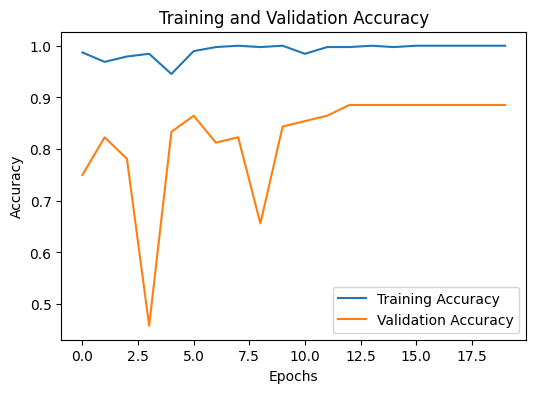

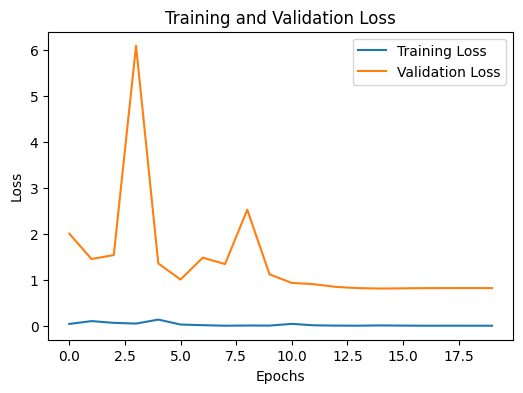

In [39]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.figure(figsize=(6, 4))

# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.figure(figsize=(6, 4))

# Loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Step 7: Confusion Matrix 

3/3 [==============================] - 1s 189ms/step


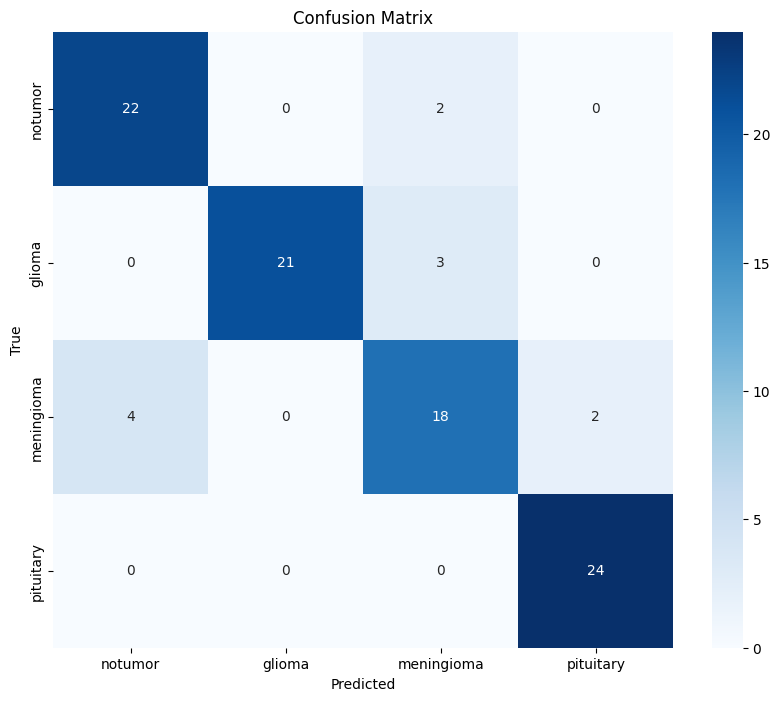

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
y_pred = model.predict(x_validate)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_validate, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()